In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import sys
import plotly.express as px
from pywaffle import Waffle
from annotated_text import annotation

In [2]:
np.__version__

'1.26.4'

In [3]:
pd.__version__

'2.2.3'

In [4]:
sys.path.insert(0, "../../pixel_year_app")

import streamlit as st
from streamlit_gsheets import GSheetsConnection
conn = st.connection("gsheets", type=GSheetsConnection)

2024-12-06 23:59:55.515 
  command:

    streamlit run /opt/anaconda3/envs/streamlit_app/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [9]:
with open("../config.yml", 'r') as f:
    cfg = yaml.safe_load(f)

In [10]:
dict_emotion_id = cfg['map_emotion_id']
dict_emotion_color = cfg['map_emotion_color']
dict_emotion_intensity_id = cfg['map_emotion_intensity_id']
dict_emotion_intensity_color = cfg['map_emotion_intensity_color']

In [5]:
dict_emotion_id

{0: 0,
 'Missing': 1,
 'Happy': 2,
 'Loved': 3,
 'Confident': 4,
 'Playful': 5,
 'Embarassed': 6,
 'Angry': 7,
 'Scared': 8,
 'Sad': 9}

In [6]:
dict_emotion_color

{0: '#ebebeb',
 'Missing': '#ffffff',
 'Happy': '#f7add6',
 'Loved': '#f2687f',
 'Confident': '#fa9c7d',
 'Playful': '#fbc779',
 'Embarassed': '#6ad2a7',
 'Angry': '#7ccdf8',
 'Scared': '#8d9dfa',
 'Sad': '#ca80e5'}

In [7]:
list(dict_emotion_color.values())

['#ebebeb',
 '#ffffff',
 '#f7add6',
 '#f2687f',
 '#fa9c7d',
 '#fbc779',
 '#6ad2a7',
 '#7ccdf8',
 '#8d9dfa',
 '#ca80e5']

In [8]:
dict_emotion_intensity_id

{0: 0, 'Missing': 1, ':((': 2, ':(': 3, ':|': 4, ':)': 5, ':))': 6}

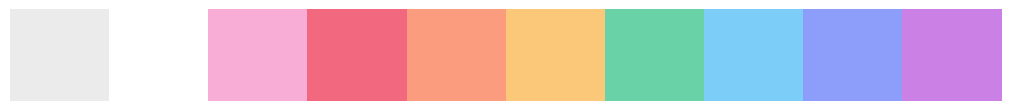

In [9]:
import matplotlib.patches as patches

def visualize_hex_codes(hex_codes, cols=5):
    """
    Visualizes a series of hex codes as colored squares.
    
    Parameters:
        hex_codes (list): List of hex color codes (e.g., ['#FF5733', '#33FF57']).
        cols (int): Number of squares per row.
    """
    rows = (len(hex_codes) + cols - 1) // cols  # Calculate number of rows needed
    fig, ax = plt.subplots(figsize=(cols, rows), layout="constrained")

    # Set axis limits and turn off axes
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.axis('off')

    # Add squares for each hex code
    for idx, hex_code in enumerate(hex_codes):
        row = idx // cols
        col = idx % cols
        square = patches.Rectangle((col, rows - 1 - row), 1, 1, linewidth=0, edgecolor='black', facecolor=hex_code)
        ax.add_patch(square)

    #plt.tight_layout()
    plt.show()

# Example usage
visualize_hex_codes(list(dict_emotion_color.values()), cols=10)

In [11]:
df_emotion = conn.read(
    worksheet="pixel_year",
    ttl="10m",
    usecols=range(13),
    nrows=31
)

df_emotion = df_emotion.rename(columns={df_emotion.columns[0]: 'id_day'})
df_emotion = df_emotion.set_index('id_day')
df_emotion = df_emotion.fillna('0')

df_emotion.head(5)

2024-12-07 00:00:31.437 No runtime found, using MemoryCacheStorageManager
2024-12-07 00:00:31.443 No runtime found, using MemoryCacheStorageManager


,January,February,March,April,May,June,July,August,September,October,November,December
id_day,,,,,,,,,,,,
1,Happy,Happy,Happy,Loved,Happy,Happy,Happy,Happy,Loved,Scared,Confident,Loved
2,Happy,Happy,Happy,Sad,Happy,Happy,Happy,Confident,Sad,Scared,Scared,Confident
3,Scared,Sad,Happy,Confident,Happy,Happy,Happy,Happy,Sad,Confident,Confident,Happy
4,Scared,Sad,Happy,Scared,Happy,Sad,Happy,Happy,Happy,Confident,Happy,Sad
5,Happy,Scared,Sad,Happy,Playful,Confident,Happy,Happy,Sad,Happy,Happy,Confident


In [12]:
df_intensity = conn.read(
    worksheet="pixel_year_intensity",
    ttl="10m",
    usecols=range(13),
    nrows=31
)

first_col = df_intensity.columns[0]
df_intensity = df_intensity.rename(columns={first_col: 'id_day'})
df_intensity = df_intensity.set_index('id_day')
df_intensity = df_intensity.fillna('0')

df_intensity.head(5)

2024-12-07 00:00:33.942 No runtime found, using MemoryCacheStorageManager


,January,February,March,April,May,June,July,August,September,October,November,December
id_day,,,,,,,,,,,,
1,:),:|,:|,:),:),:),:|,:|,:),:|,:|,:|
2,:),:),:|,:|,:),:)),:),:)),:|,:|,:(,:|
3,:|,:|,:|,:|,:|,:|,:),:)),:|,:|,:|,:|
4,:|,:|,:|,:|,:|,:|,:),:),:),:|,:|,:((
5,:),:|,:|,:),:|,:|,:),:),:|,:)),:|,:|


In [13]:
df_emotion_melt = pd.melt(df_emotion)
df_emotion_melt = df_emotion_melt[(df_emotion_melt['value']!='Missing')]
df_emotion_melt.columns = ['month', 'emotion']
df_emotion_melt['day'] = df_emotion_melt.groupby(['month']).cumcount()+1
n_days = df_emotion_melt.month.value_counts().reset_index()
df_emotion_melt = df_emotion_melt.merge(n_days, on='month', how='left')

In [14]:
n_days

,month,count
0,January,31
1,March,31
2,May,31
3,July,31
4,August,31
5,October,31
6,December,31
7,April,30
8,June,30
9,September,30


In [15]:
df_emotion_id = df_emotion.copy()

df_emotion_id = (
    pd.DataFrame([df_emotion_id[col].map(dict_emotion_id) for col in df_emotion_id.columns])
    .transpose()
    .fillna(0)
    .astype(int)
)

df_emotion_id.head(5)

,January,February,March,April,May,June,July,August,September,October,November,December
id_day,,,,,,,,,,,,
1,2,2,2,3,2,2,2,2,3,8,4,3
2,2,2,2,9,2,2,2,4,9,8,8,4
3,8,9,2,4,2,2,2,2,9,4,4,2
4,8,9,2,8,2,9,2,2,2,4,2,9
5,2,8,9,2,5,4,2,2,9,2,2,4


In [16]:
df_melt = pd.melt(df_emotion)
df_melt = df_melt[(df_melt['value']!='0') & (df_melt['value']!='Missing')]
df_melt.columns = ['month', 'emotion']
df_melt['day'] = df_melt.groupby(['month']).cumcount()+1
df_melt.head(5)

,month,emotion,day
0,January,Happy,1
1,January,Happy,2
2,January,Scared,3
3,January,Scared,4
4,January,Happy,5


In [17]:
df_count = df_melt[['month', 'emotion']].value_counts().reset_index().rename(columns={0: 'value'})
df_count.head(5)

,month,emotion,count
0,July,Happy,21
1,June,Happy,20
2,November,Happy,18
3,May,Happy,17
4,March,Happy,13


In [18]:
df_count.month.value_counts()

month
November     6
May          6
January      6
September    6
April        6
July         5
June         5
March        5
August       5
October      5
February     4
December     4
Name: count, dtype: int64

In [25]:
df_count[df_count.month=='July']

,month,emotion,count
0,July,Happy,21
30,July,Confident,4
37,July,Scared,3
46,July,Loved,2
53,July,Sad,1


In [75]:
df_count = df_count.merge(n_days, on='month', how='left')

In [76]:
df_count.columns = ['month', 'emotion', 'count', 'n_days']
df_count['perc'] = df_count['count']/df_count['n_days']

In [77]:
df_count

,month,emotion,count,n_days,perc
0,July,Happy,21,31,0.677419
1,June,Happy,20,30,0.666667
2,November,Happy,18,30,0.600000
3,May,Happy,17,31,0.548387
4,March,Happy,13,31,0.419355
...,...,...,...,...,...
56,December,Loved,1,31,0.032258
57,August,Sad,1,31,0.032258
58,April,Playful,1,30,0.033333
59,April,Loved,1,30,0.033333


In [78]:
df

,r,theta
0,1,processing cost
1,5,mechanical properties
2,2,chemical stability
3,2,thermal stability
4,3,device integration


In [81]:
df_spider = df_count[(df_count.month=='April')][['perc', 'emotion']]

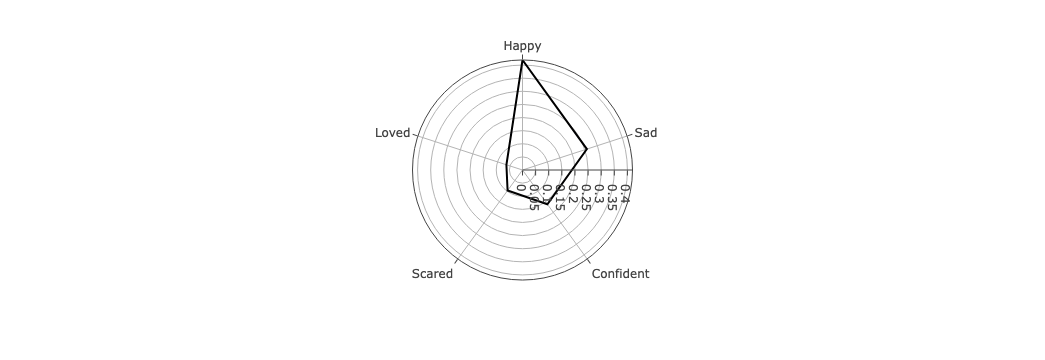

In [98]:
import plotly.express as px

month = 'March'

fig = px.line_polar(df_count[(df_count.month==month)], r='perc', theta='emotion', line_close=True)
fig.show()

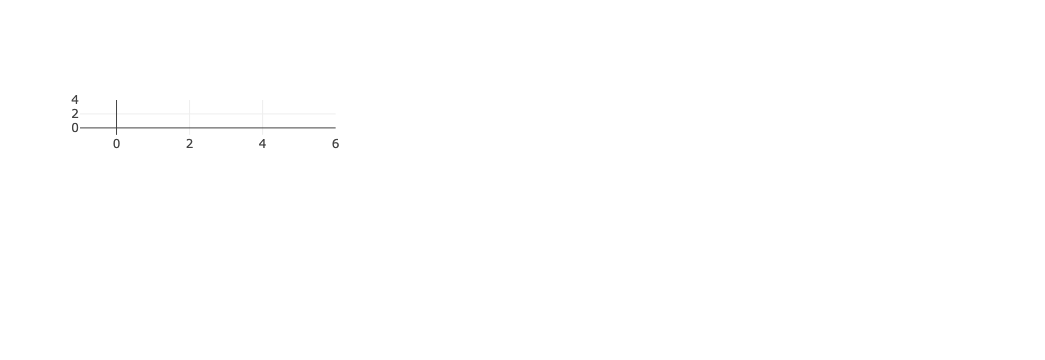

In [107]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=3)
fig

In [110]:
#specs=[[{'type': 'polar'}] * 2] * 1
specs

[[{'type': 'polar'}, {'type': 'polar'}]]

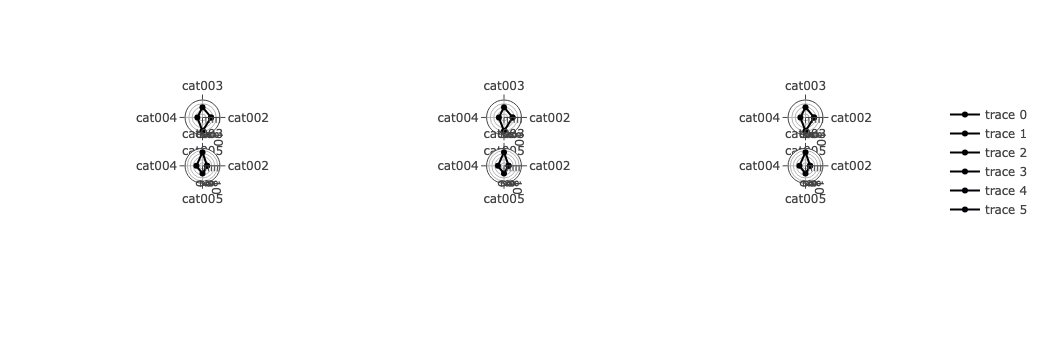

In [115]:
from plotly.subplots import make_subplots

n_rows = 4
n_cols = 3
fig = make_subplots(rows=n_rows, cols=n_cols, specs=[[{'type': 'polar'}] * n_cols] * n_rows)

fig.add_trace(
    go.Scatterpolar(
        theta=["cat002", "cat003", "cat004", "cat005", "cat002"],
        r=[5,6,3,8,5],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatterpolar(
        theta=["cat002", "cat003", "cat004", "cat005", "cat002"],
        r=[5,6,3,8,5],
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatterpolar(
        theta=["cat002", "cat003", "cat004", "cat005", "cat002"],
        r=[5,6,3,8,5],
    ),
    row=1,
    col=3,
)
fig.add_trace(
    go.Scatterpolar(
        theta=["cat002", "cat003", "cat004", "cat005", "cat002"],
        r=[3,9,4,5,3]
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatterpolar(
        theta=["cat002", "cat003", "cat004", "cat005", "cat002"],
        r=[3,9,4,5,3]
    ),
    row=2,
    col=2,
)

fig.add_trace(
    go.Scatterpolar(
        theta=["cat002", "cat003", "cat004", "cat005", "cat002"],
        r=[3,9,4,5,3]
    ),
    row=2,
    col=3,
)


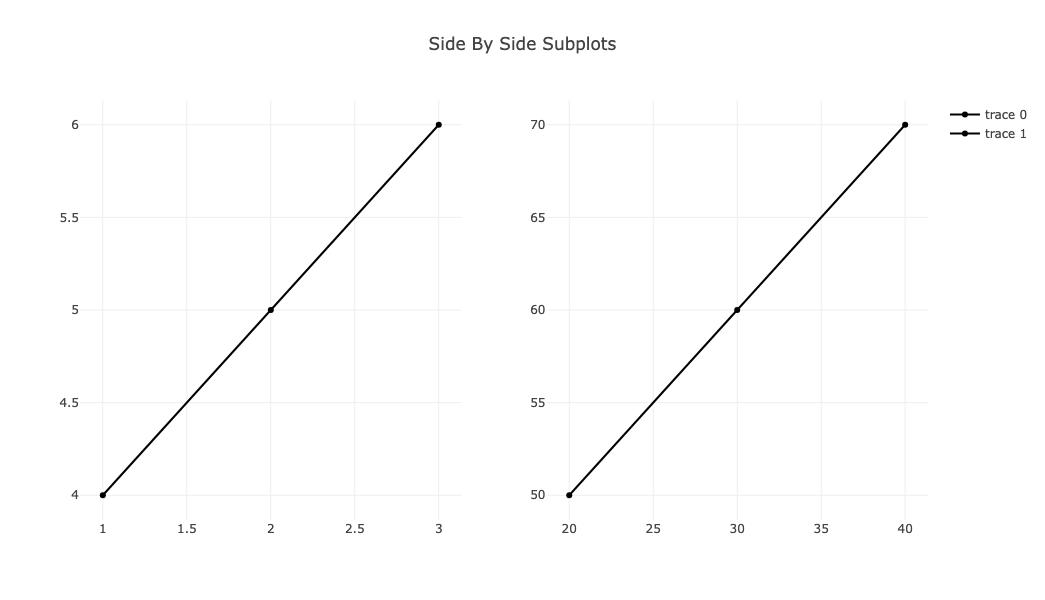

In [103]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")

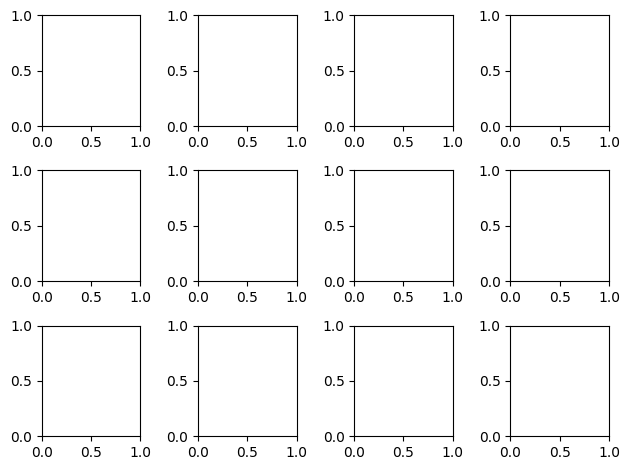

In [102]:
fig, ax = plt.subplots(3, 4)

ax[0] = px.line_polar(df_count[(df_count.month==month)], r='perc', theta='emotion', line_close=True)

fig.tight_layout()
plt.show()

In [7]:
emotions = list(dict_emotion_id.keys())[2:]
emotions = [
    'Happy',
    'Loved',
    'Confident',
    'Playful',
    'Scared',
    'Sad'
]

In [19]:
sorted_month = list(df_emotion.columns)
sorted_month.reverse()
sorted_month

['December',
 'November',
 'October',
 'September',
 'August',
 'July',
 'June',
 'May',
 'April',
 'March',
 'February',
 'January']

In [20]:
df_melt

,month,emotion,day
0,January,Happy,1
1,January,Happy,2
2,January,Scared,3
3,January,Scared,4
4,January,Happy,5
...,...,...,...
341,December,Loved,1
342,December,Confident,2
343,December,Happy,3
344,December,Sad,4


In [21]:
emotion = emotions[0]
df_filt = df_melt[df_melt.emotion==emotion]
df_plot = (df_filt.month.value_counts()/df_filt.shape[0]).reindex(sorted_month).fillna(0).reset_index()
# df_plot = df_plot.iloc[::-1, ::-1]
df_plot.head()

,month,count
0,December,0.006410
1,November,0.115385
2,October,0.070513
3,September,0.076923
4,August,0.076923


In [22]:
sorting_criteria = ['month', 'emotion']

In [23]:
df_plot.sort_values(by='count')

,month,count
0,December,0.006410
8,April,0.051282
10,February,0.064103
2,October,0.070513
3,September,0.076923
4,August,0.076923
9,March,0.083333
11,January,0.083333
7,May,0.108974
1,November,0.115385


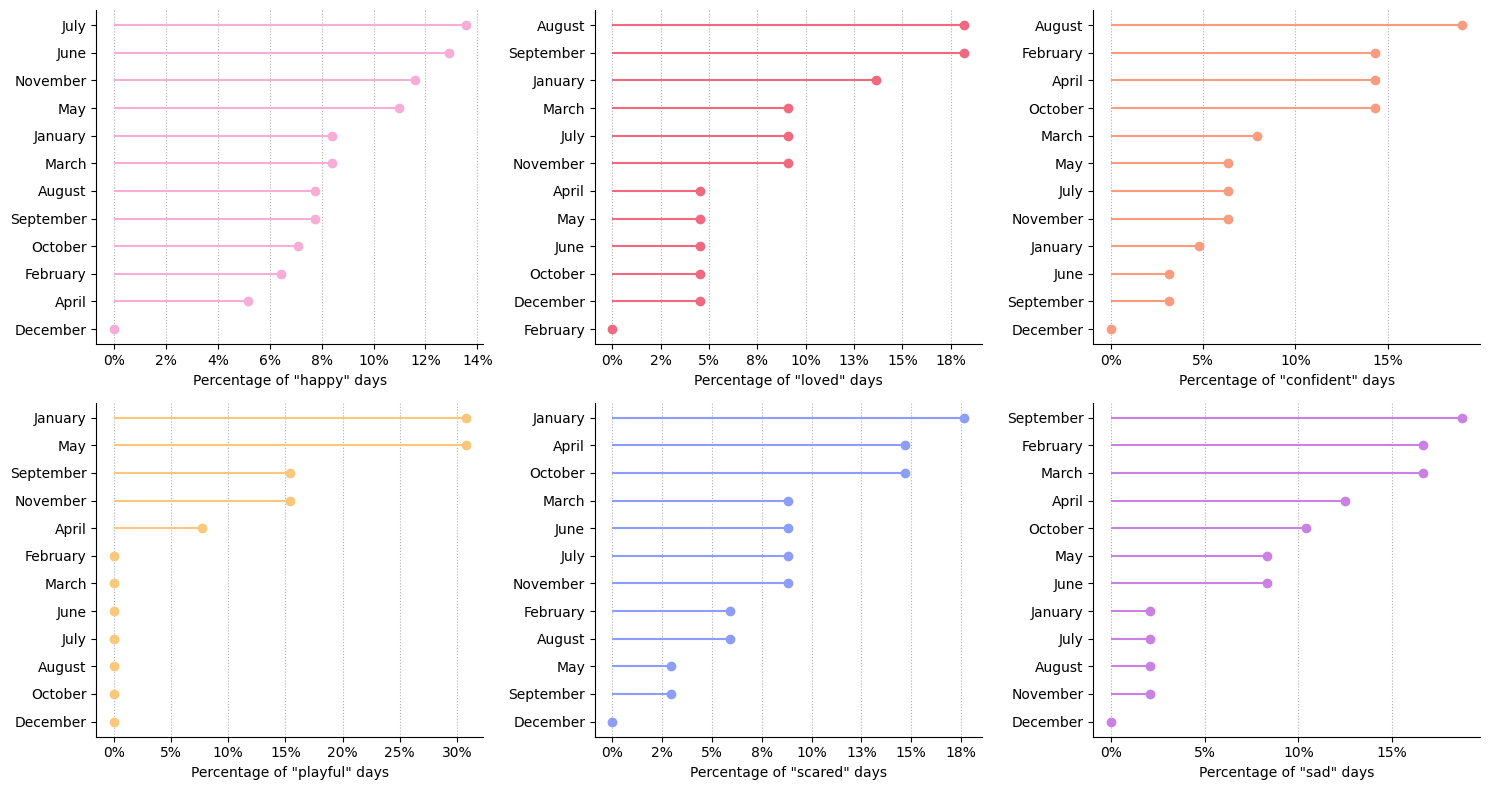

In [85]:
sorting_criteria = 'emotion'

fig, ax = plt.subplots(2, 3, figsize=(15, 8), dpi=100)
ax = ax.flatten()

for i, emotion in enumerate(emotions):
    df_filt = df_melt[df_melt.emotion==emotion]
    if sorting_criteria == 'month':
        df_plot = (df_filt.month.value_counts()/df_filt.shape[0]).reindex(sorted_month).fillna(0).reset_index()
    if sorting_criteria == 'emotion':
        df_plot = (df_filt.month.value_counts()/df_filt.shape[0]).reindex(sorted_month).fillna(0).reset_index().sort_values(by='count')
    range_plot = range(1, 1 + df_plot.shape[0])
    ax[i].hlines(y=range_plot, xmin=0, xmax=df_plot['count'], color=dict_emotion_color[emotion])
    ax[i].plot(df_plot['count'], range_plot, "o", color=dict_emotion_color[emotion])
    ax[i].set_yticks(range(1, 1+df_plot.shape[0]), df_plot['month'])
    ax[i].set_xlabel(f'Percentage of "{emotion.lower()}" days')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(axis='x', ls=':')
    vals = ax[i].get_xticks()[1:-1]
    ax[i].set_xticks(vals, ['{:,.0%}'.format(x) for x in vals])
    
plt.tight_layout()
plt.show()

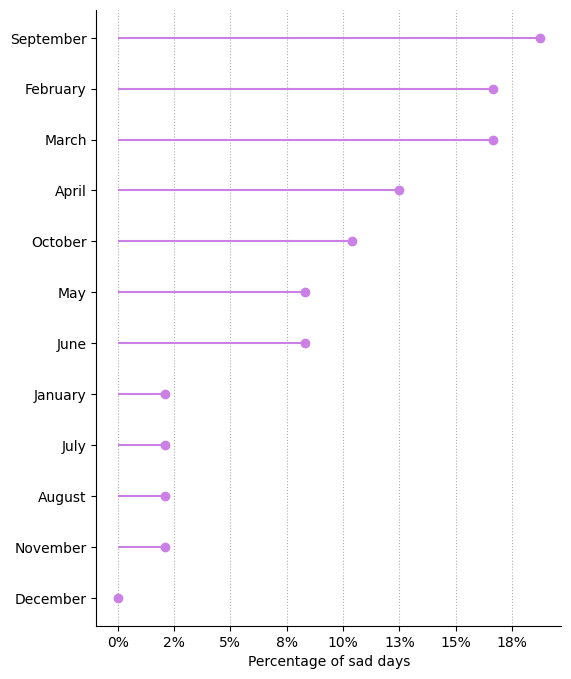

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8), dpi=100)
range_plot = range(1, 1 + df_plot.shape[0])
ax.hlines(y=range(1, 1+df_plot.shape[0]), xmin=0, xmax=df_plot['count'], color=dict_emotion_color[emotion])
ax.plot(df_plot['count'], range_plot, "o", color=dict_emotion_color[emotion])
ax.set_yticks(range(1, 1+df_plot.shape[0]), df_plot['month'])
ax.set_xlabel(f'Percentage of {emotion.lower()} days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', ls=':')
vals = ax.get_xticks()[1:-1]
ax.set_xticks(vals, ['{:,.0%}'.format(x) for x in vals])
plt.show()

In [24]:
# ranking di ogni emozione per mese
df_emotions_list = []
for emotion in emotions:
    df_filt = df_melt[df_melt.emotion==emotion]
    df_plot = (df_filt.month.value_counts()/df_filt.shape[0]).reindex(sorted_month).fillna(0).reset_index()
    df_plot.columns = ['month', emotion]
    df_emotions_list.append(df_plot)

In [25]:
from functools import reduce
df_merged = reduce(lambda left,right: pd.merge(left, right, on=['month'], how='outer'), df_emotions_list)

In [26]:
sorted_month.reverse()
df_merged = df_merged.set_index('month').reindex(sorted_month)
df_merged

,Happy,Loved,Confident,Playful,Scared,Sad
month,,,,,,
January,0.083333,0.136364,0.046154,0.307692,0.176471,0.04
February,0.064103,0.000000,0.138462,0.000000,0.058824,0.16
March,0.083333,0.090909,0.076923,0.000000,0.088235,0.16
April,0.051282,0.045455,0.138462,0.076923,0.147059,0.12
May,0.108974,0.045455,0.061538,0.307692,0.029412,0.08
June,0.128205,0.045455,0.030769,0.000000,0.088235,0.08
July,0.134615,0.090909,0.061538,0.000000,0.088235,0.02
August,0.076923,0.181818,0.184615,0.000000,0.058824,0.02
September,0.076923,0.181818,0.030769,0.153846,0.029412,0.18


In [27]:
df_merged_rank = df_merged.assign(**df_merged.rank(axis = 0, ascending = False).astype(int))

In [92]:
df_merged_rank

,Happy,Loved,Confident,Playful,Scared,Sad
month,,,,,,
January,5,3,9,1,1,9
February,10,12,3,9,8,2
March,5,5,5,9,5,2
April,11,9,3,5,2,4
May,4,9,7,1,10,6
June,2,9,10,9,5,6
July,1,5,7,9,5,9
August,7,1,1,9,8,9
September,7,1,10,3,10,1


In [28]:
df_merged_rank = pd.DataFrame({'month': df_melt.month.unique(), 'Month': range(1, 13)}).set_index('month').join(df_merged_rank)

In [61]:
df_merged_rank.sort_values(by='Happy').index

Index(['July', 'June', 'November', 'May', 'January', 'March', 'August',
       'September', 'October', 'February', 'April', 'December'],
      dtype='object', name='month')

In [93]:
mnt_list = []
for el in df_merged_rank.columns[1:]:
    mnt_data = df_merged_rank.sort_values(by=el).index
    mnt_list.append(pd.DataFrame(mnt_data).rename(columns={'month': el}))

In [97]:
df_pc = pd.concat(mnt_list, axis=1)#, ignore_index=True)
df_pc

,Happy,Loved,Confident,Playful,Scared,Sad
0,July,August,August,January,January,September
1,June,September,February,May,April,February
2,November,January,April,September,October,March
3,May,March,October,November,March,April
4,January,July,March,April,June,October
5,March,November,May,February,July,May
6,August,April,July,March,November,June
7,September,May,November,June,February,January
8,October,June,January,July,August,July
9,February,October,June,August,May,August


In [108]:
df_merged_rank = df_merged_rank.drop('Month', axis=1)
df_merged_rank

,Happy,Loved,Confident,Playful,Scared,Sad
month,,,,,,
January,5,3,9,1,1,8
February,10,12,3,9,8,2
March,5,5,5,9,5,2
April,11,9,3,5,2,4
May,4,9,7,1,10,6
June,2,9,11,9,5,6
July,1,5,7,9,5,10
August,7,1,1,9,8,10
September,7,1,11,3,10,1


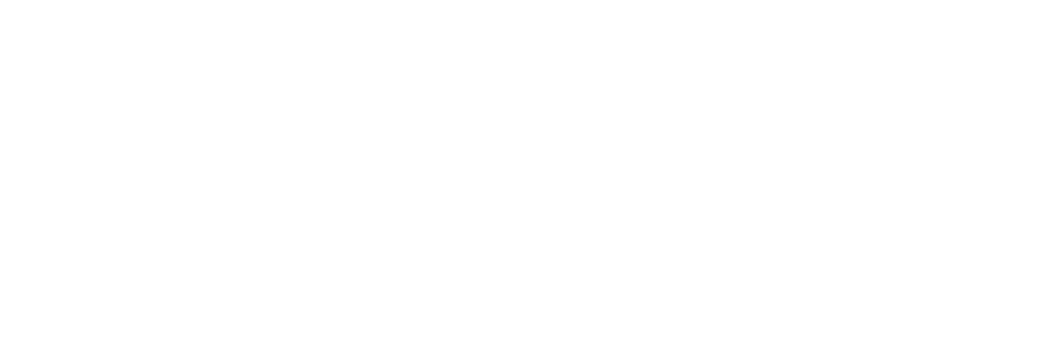

In [102]:
import plotly.express as px
fig = px.parallel_coordinates(
    df_pc,
    color_continuous_midpoint=2
    )
fig.show()

In [113]:
df_merged_rank = df_merged_rank.iloc[::-1]
df_pc = df_pc.iloc[::-1]

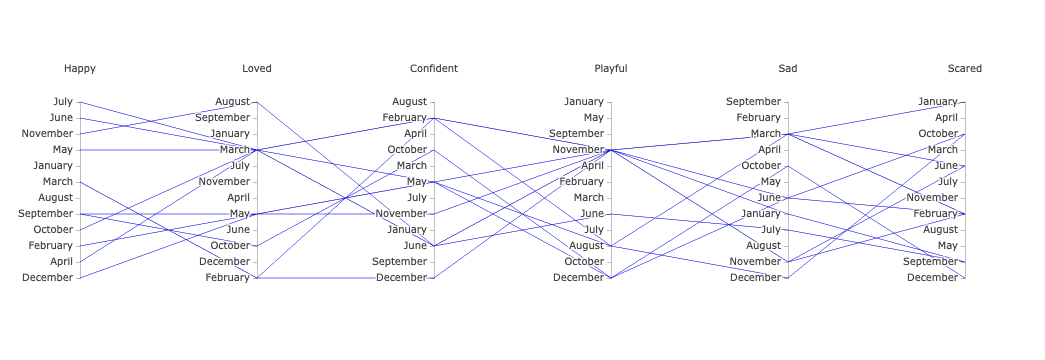

In [115]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [1, 12],
                 label = 'Happy',
                 tickvals = list(range(1, 13)),
                 values = df_merged_rank.Happy,
                 ticktext = df_pc.Happy
                ),
            dict(range = [1, 12],
                 label = 'Loved',
                 tickvals = list(range(1, 13)),
                 values = df_merged_rank.Loved,
                 ticktext = df_pc.Loved
                ),
            dict(range = [1, 12],
                 label = 'Confident',
                 tickvals = list(range(1, 13)),
                 values = df_merged_rank.Confident,
                 ticktext = df_pc.Confident
                ),
            dict(range = [1, 12],
                 label = 'Playful',
                 tickvals = list(range(1, 13)),
                 values = df_merged_rank.Playful,
                 ticktext = df_pc.Playful
                ),
            dict(range = [1, 12],
                 label = 'Sad',
                 tickvals = list(range(1, 13)),
                 values = df_merged_rank.Sad,
                 ticktext = df_pc.Sad
                ),
            dict(range = [1, 12],
                 label = 'Scared',
                 tickvals = list(range(1, 13)),
                 values = df_merged_rank.Scared,
                 ticktext = df_pc.Scared
                ),
        ])
    )
)
fig.show()

In [104]:
import plotly.express as px
fig = px.parallel_coordinates(
    df_merged_rank,
    color_continuous_midpoint=2
    )

fig.update_layout(
    coloraxis_showscale=False,
    #hovermode="x unified",
    xaxis1=dict(
        tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # Indices for the months (0 to 11)
        ticktext=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],  # Custom month labels
    ),
    dimensions = list([
            dict(range = [1,12],
                 values = [1,4]),
            dict(range = [1.5,5],
                 values = [3,1.5]),
            dict(range = [1,5],
                 values = [2,4]),
            dict(range = [1,5],
                 values = [4,2])
        ])
)
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Layout: 'dimensions'

Did you mean "selections"?

    Valid properties:
        activeselection
            :class:`plotly.graph_objects.layout.Activeselection`
            instance or dict with compatible properties
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. This is the default
            value; however it could be overridden for individual
            axes.
        barcornerradius
            Sets the rounding of bar corners. May be an integer
            number of pixels, or a percentage of bar width (as a
            string ending in %).
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to reduce
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        computed
            Placeholder for exporting automargin-impacting values
            namely `margin.t`, `margin.b`, `margin.l` and
            `margin.r` in "full-json" mode.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendiciclecolors
            If `true`, the icicle slice colors (whether given by
            `iciclecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to reduce "opacity" to
            see multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            `hiddenlabels`.
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled.
        hoversubplots
            Determines expansion of hover effects to other subplots
            If "single" just the axis pair of the primary point is
            included without overlaying subplots. If "overlaying"
            all subplots using the main axis and occupying the same
            space are included. If "axis", also include stacked
            subplots using the same axis when `hovermode` is set to
            "x", *x unified*, "y" or *y unified*.
        iciclecolorway
            Sets the default icicle slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendiciclecolors`.
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        minreducedheight
            Minimum height of the plot with margin.automargin
            applied (in px)
        minreducedwidth
            Minimum width of the plot with margin.automargin
            applied (in px)
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newselection
            :class:`plotly.graph_objects.layout.Newselection`
            instance or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        scattergap
            Sets the gap (in plot fraction) between scatter points
            of adjacent location coordinates. Defaults to `bargap`.
        scattermode
            Determines how scatter points at the same location
            coordinate are displayed on the graph. With "group",
            the scatter points are plotted next to one another
            centered around the shared location. With "overlay",
            the scatter points are plotted over one another, you
            might need to reduce "opacity" to see multiple scatter
            points.
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        selections
            A tuple of
            :class:`plotly.graph_objects.layout.Selection`
            instances or dicts with compatible properties
        selectiondefaults
            When used in a template (as
            layout.template.layout.selectiondefaults), sets the
            default property values to use for elements of
            layout.selections
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        smith
            :class:`plotly.graph_objects.layout.Smith` instance or
            dict with compatible properties
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.title.font instead. Sets
            the title font. Note that the title's font used to be
            customized by the now deprecated `titlefont` attribute.
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to reduce "opacity" to see
            multiple bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        
Did you mean "selections"?

Bad property path:
dimensions
^^^^^^^^^^

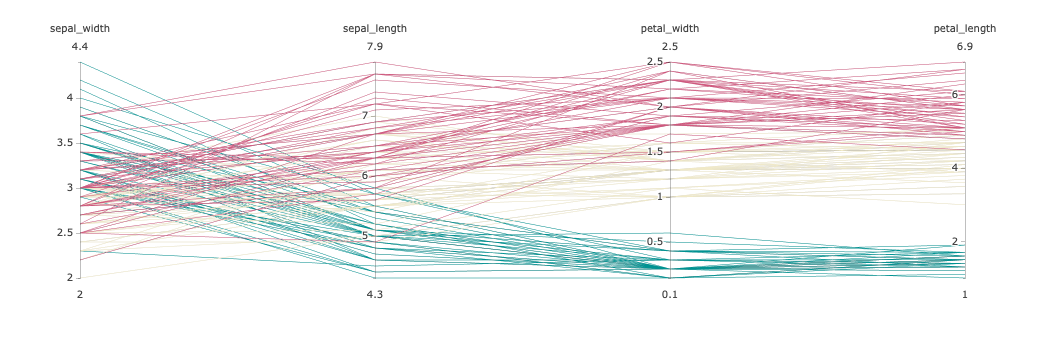

In [251]:
import plotly.express as px
df = px.data.iris()
fig = px.parallel_coordinates(df, color="species_id",
                              dimensions=['sepal_width', 'sepal_length', 'petal_width',
                                          'petal_length'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.update_layout(coloraxis_showscale=False)
fig.show()

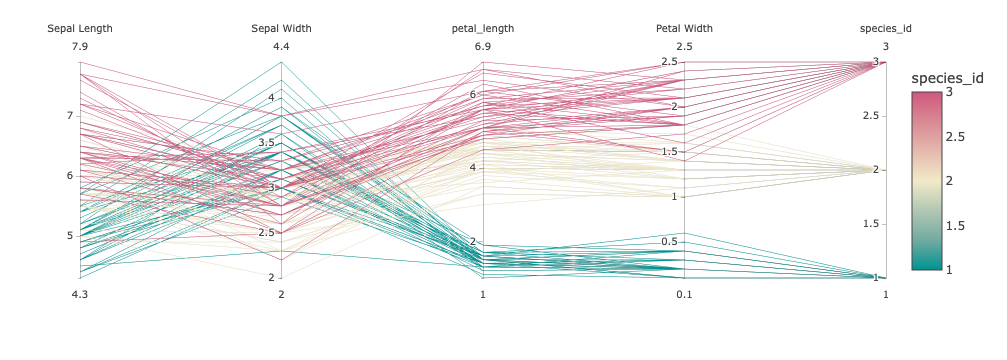

In [250]:
import plotly.express as px

# Load the iris dataset provided by the library
df = px.data.iris()

# Create the chart:
fig = px.parallel_coordinates(
    df, 
    color="species_id", 
    labels={"sepal_width": "Sepal Width", "sepal_length": "Sepal Length", "petal_width": "Petal Width"},
    color_continuous_scale=px.colors.diverging.Tealrose)
#    color_continuous_midpoint=2)

# Hide the color scale that is useless in this case
fig.update_layout(coloraxis_showscale=False)

# Show the plot
fig.show()

In [247]:
df_emotion_melt

,month,emotion,day,count
0,January,Happy,1,31
1,January,Happy,2,31
2,January,Scared,3,31
3,January,Scared,4,31
4,January,Happy,5,31
...,...,...,...,...
361,December,0,27,31
362,December,0,28,31
363,December,0,29,31
364,December,0,30,31


In [242]:
df

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,3
146,6.3,2.5,5.0,1.9,virginica,3
147,6.5,3.0,5.2,2.0,virginica,3
148,6.2,3.4,5.4,2.3,virginica,3


In [182]:
import matplotlib.ticker as mtick

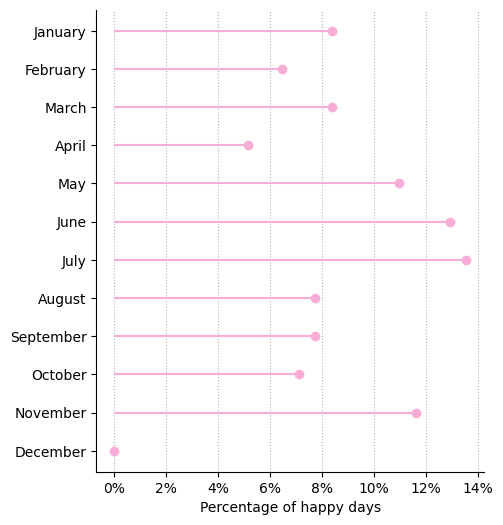

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6), dpi=100)
 
ax.hlines(y=range(1, 1+df_plot.shape[0]), xmin=0, xmax=df_plot['count'], color=dict_emotion_color[emotion])
ax.plot(df_plot['count'], my_range, "o", color=dict_emotion_color[emotion])
ax.set_yticks(range(1, 1+df_plot.shape[0]), df_plot['month'])
ax.set_xlabel(f'Percentage of {emotion.lower()} days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', ls=':')
vals = ax.get_xticks()[1:-1]
ax.set_xticks(vals, ['{:,.0%}'.format(x) for x in vals])
plt.show()

In [197]:
vals = ax.get_xticks()[1:-1]
vals

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14])

In [ ]:
# variables recorded per month
# - n of 

### Days of the week

In [18]:
import datetime
from time import strptime

In [19]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [20]:
dict_emotion_id_2 = {
    'Happy': 1,
    'Loved': 2,
    'Confident': 3,
    'Playful': 4,
    'Scared': 5,
    'Sad': 6,
    'Angry': 7
}

In [21]:
dict_emotion_color_2 = {
    1: '#f7add6',
    2: '#f2687f',
    3: '#fa9c7d',
    4: '#fbc779',
    5: '#8d9dfa',
    6: '#ca80e5',
    7: '#7ccdf8'
}

In [22]:
df_days = df_melt.copy()
df_days['month_abb'] = [el[:3] for el in df_melt.month]
df_days['month_id'] = df_days['month_abb'].apply(lambda x: strptime(x,'%b').tm_mon)
df_days['date'] = [datetime.datetime(year=2024, month=el[0], day=el[1]) for el in zip(df_days.month_id, df_days.day)]
df_days['weekday_id'] = df_days['date'].apply(lambda x: x.weekday()+1)
df_days['weekday'] = df_days['date'].apply(lambda x: days[x.weekday()])
df_days['emotion_id'] = df_days.emotion.map(dict_emotion_id_2)#.astype(int)

In [23]:
df_days.head(5)

,month,emotion,day,month_abb,month_id,date,weekday_id,weekday,emotion_id
0,January,Happy,1,Jan,1,2024-01-01,1,Monday,1
1,January,Happy,2,Jan,1,2024-01-02,2,Tuesday,1
2,January,Scared,3,Jan,1,2024-01-03,3,Wednesday,5
3,January,Scared,4,Jan,1,2024-01-04,4,Thursday,5
4,January,Happy,5,Jan,1,2024-01-05,5,Friday,1


In [42]:
df_days_counts = df_days[['weekday', 'emotion']].value_counts().reset_index()

df_agg_weekday = df_days.weekday.value_counts().reset_index().rename(columns={'count': 'n_weekday'})
df_agg_emotion = df_days.emotion.value_counts().reset_index().rename(columns={'count': 'n_emotion'})

In [43]:
df_days_counts = df_days_counts.merge(df_agg_weekday, on='weekday', how='left').merge(df_agg_emotion, on='emotion', how='left')
df_days_counts['perc_emotion'] = df_days_counts['count']/df_days_counts['n_emotion']
df_days_counts['perc_weekday'] = df_days_counts['count']/df_days_counts['n_weekday']
df_days_counts['emotion_color'] = df_days_counts.emotion.map(dict_emotion_color)
df_days_counts.head()

,weekday,emotion,count,n_weekday,n_emotion,perc_emotion,perc_weekday,emotion_color
0,Monday,Happy,28,48,155,0.180645,0.583333,#f7add6
1,Friday,Happy,28,48,155,0.180645,0.583333,#f7add6
2,Wednesday,Happy,24,48,155,0.154839,0.500000,#f7add6
3,Saturday,Happy,22,48,155,0.141935,0.458333,#f7add6
4,Thursday,Happy,21,48,155,0.135484,0.437500,#f7add6


In [28]:
df_days_counts = df_days_counts.sort_values(by='emotion')

In [71]:
import plotly.graph_objects as go

def days_emotion_chart(df_days_counts, perc_feature):
    fig = go.Figure()
    
    # Add the scatter trace
    fig.add_trace(
        go.Scatter(
            x=df_days_counts.weekday,
            y=df_days_counts.emotion,
            mode='markers',
            marker=dict(
                symbol='square',
                color=df_days_counts.emotion_color,
                size=df_days_counts[perc_feature],
                sizemode='area',
                sizeref=2.*max(df_days_counts[perc_feature])/(40.**2),
                sizemin=4
            ),
            text=df_days_counts['count'],  # Optional if you want additional hover details
            hovertemplate=(
                "Weekday: %{x}<br>"
                "Emotion: %{y}<br>"
                "Number of times: %{text}<br>"  # Absolute value
                "Percentage: %{marker.size:.2f}%"  # Use size for percentage
            )
        )
    )
    
    # Set the aspect ratio to 1:1
    fig.update_layout(
        xaxis=dict(
            categoryorder="array",  # Sort by array order
            categoryarray=days,  # Specify the order
        ),
        yaxis=dict(
            categoryorder="array",  # Sort by array order
            categoryarray=list(dict_emotion_id_2.keys()),  # Specify the order
        ),
        autosize=False,
        #width=400,  # Fixed width
        #height=500,  # Fixed height
        margin=dict(l=50, r=50, t=50, b=50),  # Margins
        template="plotly_white",  # Clean look
        scene=dict(aspectmode="cube")  # Enforce equal scaling for all axes
    )
    
    fig.show()

In [120]:
import streamlit
streamlit.__version__

'1.29.0'

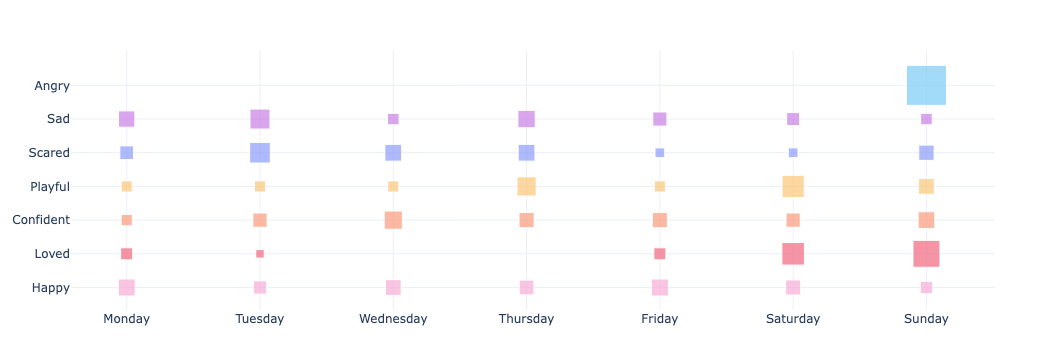

In [72]:
days_emotion_chart(df_days_counts, perc_feature='perc_emotion')

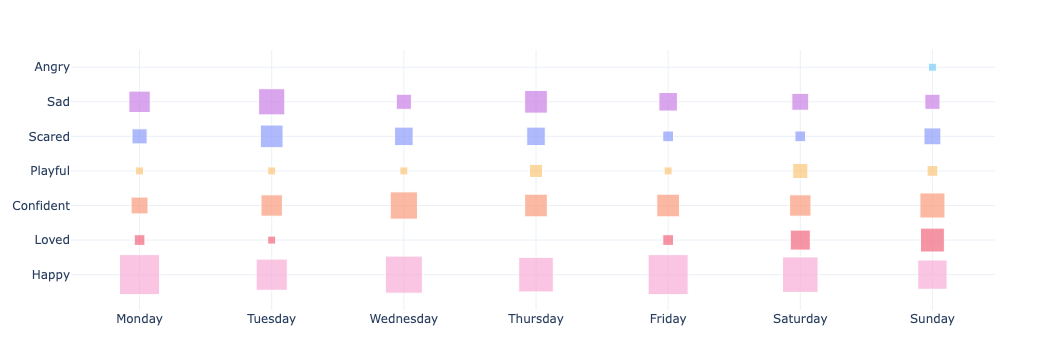

In [73]:
days_emotion_chart(df_days_counts, perc_feature='perc_weekday')

In [116]:
perc_feature='perc_weekday'

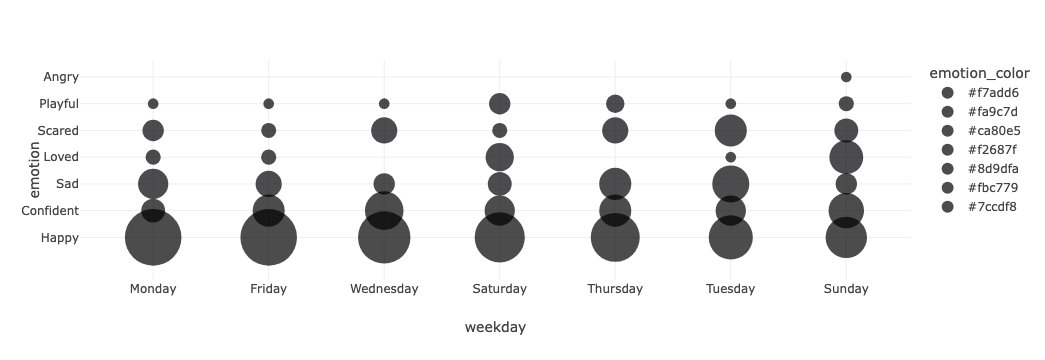

In [119]:
fig = px.scatter(
    df_days_counts,
    x='weekday',
    y='emotion',
    color='emotion_color',
    size=perc_feature,
    size_max=40,
    hover_name='count',
    hover_data={
        'emotion_color': False,  # Hide emotion color from hover
        perc_feature: False,  # Hide percentage from hover
    }
)
fig.show()

In [ ]:


# Customize hover template
fig.update_traces(
    hovertemplate=(
        "Weekday: %{x}<br>"
        "Emotion: %{y}<br>"
        "Number of times: %{customdata[0]}<br>"  # Absolute value
        "Percentage: %{marker.size:.2f}%"  # Use size for percentage
    ),
    customdata=df_days_counts[['count']].values  # Add count for hover text
)

# Set the aspect ratio to 1:1
fig.update_layout(
    xaxis=dict(
        categoryorder="array",  # Sort by array order
        categoryarray=days,  # Specify the order
    ),
    yaxis=dict(
        categoryorder="array",  # Sort by array order
        categoryarray=list(dict_emotion_id_2.keys()),  # Specify the order of emotion categories
    ),
    autosize=False,
    width=500,  # Fixed width
    height=500,  # Fixed height
    margin=dict(l=50, r=50, t=50, b=50),  # Margins
    template="plotly_white",  # Clean look
    showlegend=False  # Hide legend (if not needed)
)